In [ ]:
using Bolt, Plots, ForwardDiff

FRW Background setup

In [ ]:
# Assign cosmological parameters
𝕡 = CosmoParams(Ω_c = 0.3) # set kwargs like so to change the default values

function FRW_setup(𝕡)
    # Compute expansion history quantities
    bg = Background(𝕡)
    # Compute ionization history (via RECFAST)
    𝕣 = Bolt.RECFAST(bg=bg, Yp=𝕡.Y_p, OmegaB=𝕡.Ω_b, OmegaG=𝕡.Ω_r)
    ih = IonizationHistory(𝕣, 𝕡, bg)
    return bg,ih
end

bg,ih = FRW_setup(𝕡)

### $P_{L}(k)$

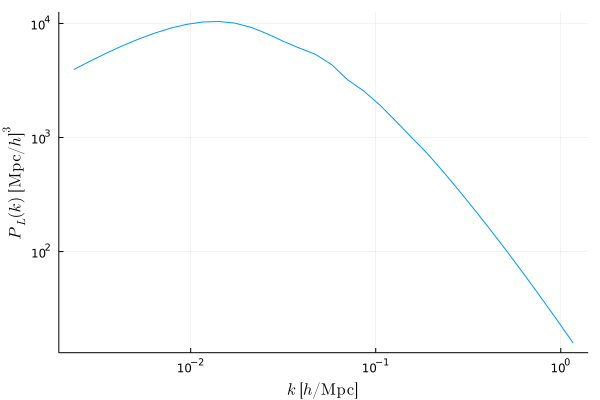

In [3]:
# Matter power spectrum
kmin,kmax,nk = 10bg.H₀,5000bg.H₀,32
ks = log10_k(kmin,kmax,nk) # k grid
pL = [plin(k,𝕡,bg,ih) for k in ks]
p1 = plot(ks, vcat(pL...), xscale=:log10, yscale=:log10,label=false,
          xlabel=raw"$k \ [h/\mathrm{Mpc}]$", ylabel=raw"$P_L(k) \ [\mathrm{Mpc}/h]^3$")

In [ ]:
# Gradient wrt Ω_c
# Define a function that changes 𝕡 - need to recompute background components, as they depend on Ω_c
function pL_Ω_c(Ω_c::T) where T # type-stable wrapper
    𝕡 = CosmoParams{T}(Ω_c=Ω_c)
    bg,ih = FRW_setup(𝕡)
    pL = zeros(T,length(ks))
    for (i_k,k) in enumerate(ks) pL[i_k] = plin(k,𝕡,bg,ih)[1] end
    return pL
end
∂pL_Ω_c = ForwardDiff.derivative(pL_Ω_c,0.3)

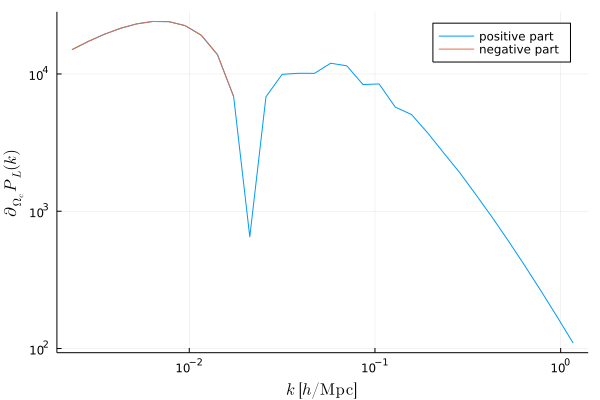

In [21]:
mp,mm = ∂pL_Ω_c.>=0, ∂pL_Ω_c.<=0
plot(ks,abs.(∂pL_Ω_c), xscale=:log10, yscale=:log10,label="positive part",
          xlabel=raw"$k \ [h/\mathrm{Mpc}]$", ylabel=raw"$\partial_{\Omega_c} P_L(k)$")
plot!(ks[mm],-∂pL_Ω_c[mm], xscale=:log10, yscale=:log10,label="negative part") #the negative contribution

### $C^{TT}(\ell)$

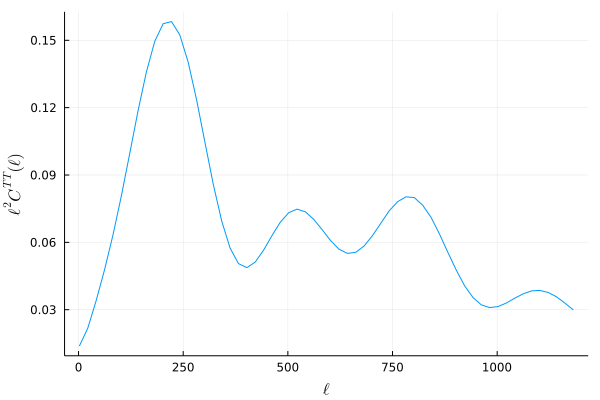

In [22]:
# CMB Cᵀᵀ(ℓ)
ℓmin,ℓmax,nℓ = 2,20,1200
ℓs = ℓmin:ℓmax:nℓ
kmin,kmax,nk = 0.1bg.H₀, 1000bg.H₀, 100
ks = quadratic_k(kmin,kmax,nk)
sf = source_grid(𝕡, bg, ih, ks, BasicNewtonian()) # set up LOS source function interpolator
Cᵀᵀ = cltt(ℓs, 𝕡, bg, ih, sf)
p2 = plot(ℓs, @.(ℓs^2*Cᵀᵀ),label=false,xlabel=raw"$\ell$", ylabel=raw"$\ell^2 C^{TT}(\ell)$")

In [ ]:
# gradient wrt Ω_b
function Cᵀᵀ_Ω_b(Ω_b::T) where T # type-stable wrapper
    𝕡 = CosmoParams{T}(Ω_b=Ω_b)
    bg,ih = FRW_setup(𝕡)
    sf = source_grid(𝕡, bg, ih, ks, BasicNewtonian())
    return cltt(ℓs, 𝕡, bg, ih, sf)
end
∂Cᵀᵀ_Ω_b = ForwardDiff.derivative(Cᵀᵀ_Ω_b,0.045)

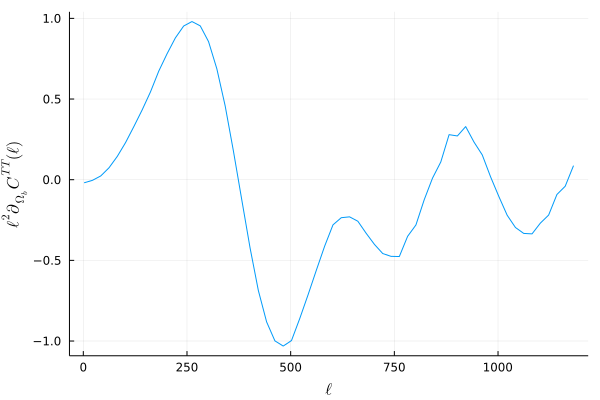

In [24]:
plot(ℓs, @.(ℓs^2*∂Cᵀᵀ_Ω_b), label=false,
          xlabel=raw"$\ell$", ylabel=raw"$\ell^2 \partial_{\Omega_b} C^{TT}(\ell)$")
